
# 2.2-kW induction motor

This example simulates sensorless flux-vector control of a 2.2-kW induction
machine drive.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np

from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, NominalValues, InductionMachineInvGammaPars,
    InductionMachinePars, plot, Sequence)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

Configure the system model.



In [4]:
# Unsaturated machine model, using its inverse-Γ parameters
par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
mdl_par = InductionMachinePars.from_inv_gamma_model_pars(par)
machine = model.InductionMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system.



In [5]:
# Set nominal values and limits for reference generation
cfg = control.FluxVectorControlCfg(.95*base.psi, 1.5*base.i, 1.5*nom.tau)
ctrl = control.FluxVectorControl(par, cfg, J=.015, T_s=250e-6, sensorless=True)

Set the speed reference and the external load torque.



In [6]:
# Speed reference (electrical rad/s)
times = np.array([0, .125, .25, .375, .5, .625, .75, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, -1, -1, 0, 0])*base.w
ctrl.ref.w_m = Sequence(times, values)
# External load torque
times = np.array([0, .125, .125, .875, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, 0])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

# No load, field-weakening (uncomment to try)
# ctrl.ref.w_m = lambda t: (t > .2)*2*base.w
# mdl.mechanics.tau_L = lambda t: 0

Create the simulation object and simulate it.



In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=4)

Plot results in per-unit values.



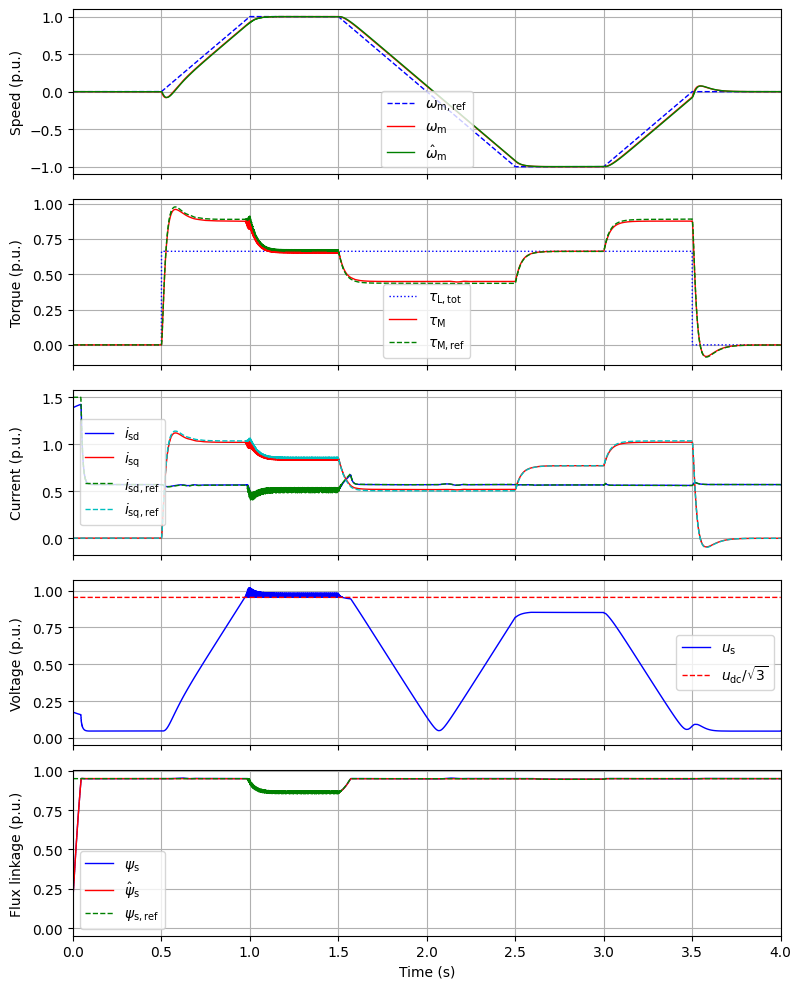

In [8]:
plot(sim, base)